In [1]:
import math
import pandas as pd 
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

import h3 # h3 bins from uber

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
import sys
sys.path.append('../Scripts')
import capstone_functions as cf

# Exploring Model Complexity vs Scores
### In this workbook we slowly add complexity to the partitioning model across a number of dimensions.   
We use the predicted values for first half (h1) 2019 as the train values and the actual h1 2019 calues as the test set.  
Finally we submit to zindi to get a score against the actual h2 2019 accident data.

## Baseline_model
Uses simple grid based on quatiles to place ambulances around the city
Zindi score = 68.9760227569434

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using star grid for placement
1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.07503016990729658
Score on train set: 0.05597306216241996 (avg distance per accident)
20201217_prediction_0.0_baseline_baseline.csv saved in ../Outputs/


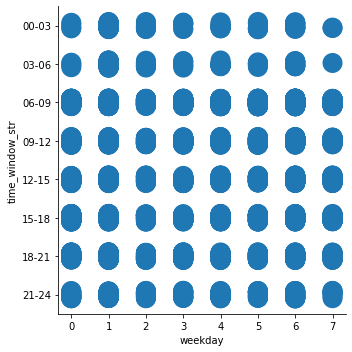

In [4]:
cf.full_pipeline(predict_period='2019_h1', frequency_cutoff=0, outlier_filter=0.00, test_period_date_start='2019-01-01', test_period_date_end='2020-07-01',
                                 tw_cluster_strategy='baseline', placement_method='baseline', verbose=2)

## Adding complexity 1
Use Partioning algorithm k_means to find optimal location for ambulances that minimizes the euclidean distance between ambulances and points

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-means clustering
1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.05897960880522698
Score on train set: 0.05054601342218318 (avg distance per accident)
20201217_prediction_0.0_baseline_k_means.csv saved in ../Outputs/


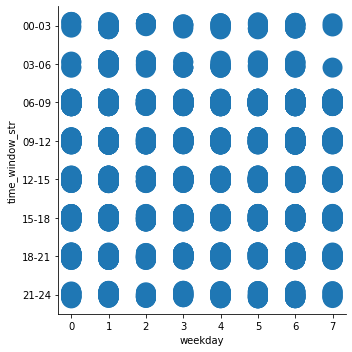

In [5]:
cf.full_pipeline(predict_period='2019_h1', frequency_cutoff=0, outlier_filter=0.00, test_period_date_start='2019-01-01', test_period_date_end='2020-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=2)

## Adding Complexity 2
Choose different algorithm that is not so influenced by outliers. Picks a median point as the cluster center.  
zindi score = 49.9372135333768

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-medoids clustering
1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.05519941541897019
Score on train set: 0.040379031163907037 (avg distance per accident)
20201217_prediction_0.0_baseline_k_medoids.csv saved in ../Outputs/


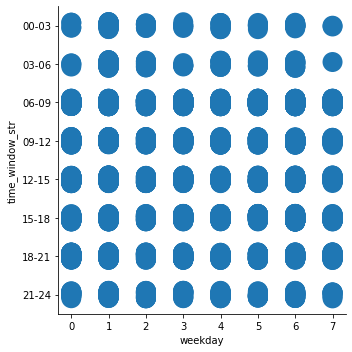

In [6]:
cf.full_pipeline(predict_period='2019_h1', frequency_cutoff=0, outlier_filter=0.00, test_period_date_start='2019-01-01', test_period_date_end='2020-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_medoids', verbose=2)

## Adding Complexity 3 
Filter outliers to reduce overfitting for rare events out side of the center of the city

zindi score = 44.4289573474198

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using k-means clustering
1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.05021612166332715
Score on train set: 0.03475499111996446 (avg distance per accident)
20201217_prediction_0.003_baseline_k_means.csv saved in ../Outputs/


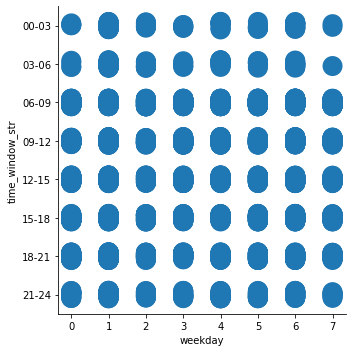

In [7]:
cf.full_pipeline(predict_period='2019_h1', frequency_cutoff=0, outlier_filter=0.003, test_period_date_start='2019-01-01', test_period_date_end='2020-07-01',
                                 tw_cluster_strategy='baseline', placement_method='k_means', verbose=2)

## Adding Complexity 4
Using gradient descent to optimize placement by reducing loss funtion that is euclidean distance between centroids and points.  
zindi score = 56.49581082745

file created ../Inputs/predictions_for_clustering_c.csv
1 clusters created
using gradient descent clustering
1 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.06169501641428757
Score on train set: 0.029772715695369757 (avg distance per accident)
20201217_prediction_0.003_baseline_gradient_descent.csv saved in ../Outputs/


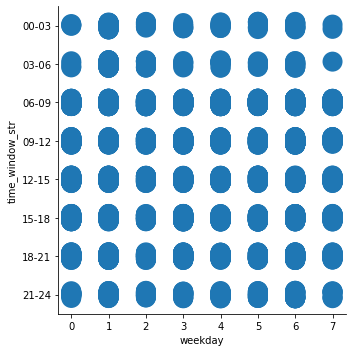

In [8]:
cf.full_pipeline(predict_period='2019_h1', frequency_cutoff=0, outlier_filter=0.003, test_period_date_start='2019-01-01', test_period_date_end='2020-07-01',
                                 tw_cluster_strategy='baseline', placement_method='gradient_descent', verbose=2,
                                 lr=8e-3, n_epochs=50, batch_size=2)

## Adding Complexity 5
Creating different placement sets for different time and day combinations
zindi score = 43.9846518426706

file created ../Inputs/predictions_for_clustering_c.csv
5 clusters created
using k-means clustering
5 placement sets created
Total size of test set: 1922
Total size of train set: 3227
Score on test set: 0.05199322505912626
Score on train set: 0.03587050084914429 (avg distance per accident)
20201217_prediction_0.004_holiday_simple_k_means.csv saved in ../Outputs/


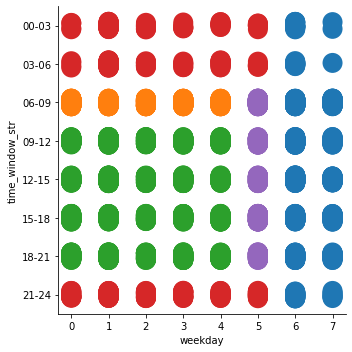

In [9]:
cf.full_pipeline(predict_period='2019_h1', frequency_cutoff=0, outlier_filter=0.004, test_period_date_start='2019-01-01', test_period_date_end='2020-07-01',
                                 tw_cluster_strategy='holiday_simple', placement_method='k_means', verbose=2)